In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
from spectral import *
import spectral.io.envi as envi

In [2]:
def calculate_WSS(points, kmax):
    sse=[]
    
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        
        curr_sse=0
    #calculate square of Euclidean distance of each point to cluster center and add to WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i,0] - curr_center[0])**2 + (points[i,1] - curr_center[1])**2
            
        sse.append(curr_sse)
    return sse

def extract_pixels(data):
    q = data.reshape(-1,data.shape[2])
    df = pd.DataFrame(data = q)
    df.columns= [f'band{i+10}' for i in range(1, 1+data.shape[2])]
    #df.to_csv('G:/ham_quality_analysis/Dataset.csv')
    return df
#k = [1,2,3,4,5,6,7,8,9,10]
#wss = calculate_WSS(X, 10)
#print(len(wss))

In [3]:
img = envi.open("G:/ham_quality_analysis/SPECIM_IQ/data_IQ_samples/2020-07-17_008/results/REFLECTANCE_2020-07-17_008.hdr",
               "G:/ham_quality_analysis/SPECIM_IQ/data_IQ_samples/2020-07-17_008/results/REFLECTANCE_2020-07-17_008.dat")

(100, 200, 204)


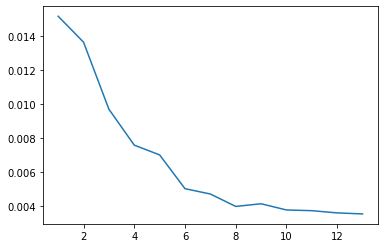

In [4]:
data = img.load()[150:250,100:300]
print(data.shape)

k = [1,2,3,4,5,6,7,8,9,10, 11, 12, 13]
#for band in range(204):
wss = calculate_WSS(data.read_band(150), 13)
plt.figure()
plt.plot(k,wss)

12


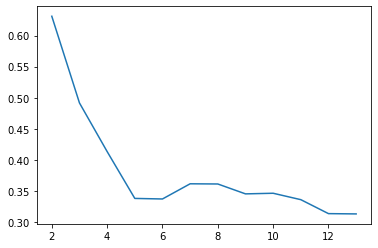

In [5]:
#Now the silhouette method
from sklearn.metrics import silhouette_score

sil=[]
kmax=13
for i in range(2,kmax+1):
    km = KMeans(n_clusters=i).fit(data.read_band(150))
    labels = km.labels_
    sil.append(silhouette_score(data.read_band(150), labels, metric='euclidean'))
print(len(sil))
k = [1,2,3,4,5,6,7,8,9,10,11,12,13]
k1 = k[1:]
plt.figure()
plt.plot(k1,sil)

spectral:INFO: k-means iteration 1 - 19994 pixels reassigned.
spectral:INFO: k-means iteration 2 - 2443 pixels reassigned.
spectral:INFO: k-means iteration 3 - 1352 pixels reassigned.
spectral:INFO: k-means iteration 4 - 1031 pixels reassigned.
spectral:INFO: k-means iteration 5 - 815 pixels reassigned.
spectral:INFO: k-means iteration 6 - 676 pixels reassigned.
spectral:INFO: k-means iteration 7 - 552 pixels reassigned.
spectral:INFO: k-means iteration 8 - 422 pixels reassigned.
spectral:INFO: k-means iteration 9 - 315 pixels reassigned.
spectral:INFO: k-means iteration 10 - 248 pixels reassigned.
spectral:INFO: k-means iteration 11 - 197 pixels reassigned.
spectral:INFO: k-means iteration 12 - 155 pixels reassigned.
spectral:INFO: k-means iteration 13 - 98 pixels reassigned.
spectral:INFO: k-means iteration 14 - 73 pixels reassigned.
spectral:INFO: k-means iteration 15 - 71 pixels reassigned.
spectral:INFO: k-means iteration 16 - 43 pixels reassigned.
spectral:INFO: k-means iteration

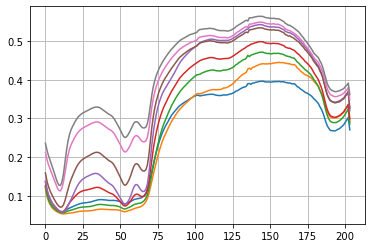

In [6]:
(m,c)= kmeans(data,8,30)
plt.figure()
for i in range(c.shape[0]):
    plt.plot( c[i])
plt.grid()

C:\Anaconda2\envs\hyperspy\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''
C:\Anaconda2\envs\hyperspy\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


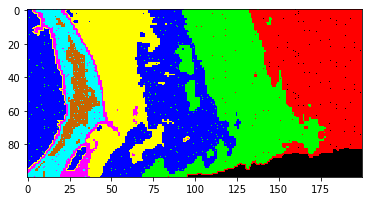

In [7]:
v = imshow(classes=m)

In [8]:
classes = create_training_classes(data,m)

spectral:INFO: Setting min samples to 204


Processing...  0.0Processing... 14.3Processing... 28.6Processing... 42.9Processing... 57.1Processing... 71.4Processing... 85.7Processing... 100.Processing...done   


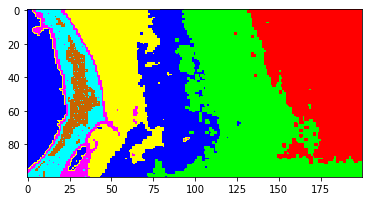

In [9]:
#Gaussian Classifier
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(data)
v = imshow(classes=clmap)

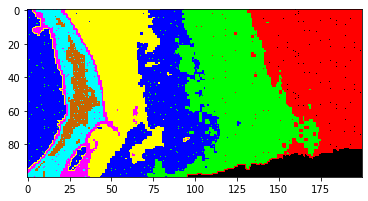

In [10]:
gtresults = clmap * (m != 0)
v = imshow(classes=gtresults)

spectral:INFO: Setting min samples to 6


204
Processing...  0.0Processing... 14.3Processing... 28.6Processing... 42.9Processing... 57.1Processing... 71.4Processing... 85.7Processing... 100.Processing...done   


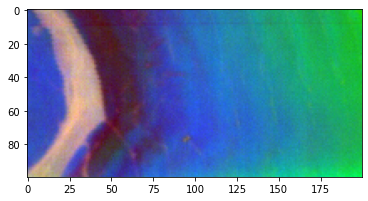

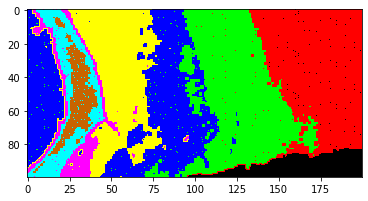

In [11]:
#Fischer Linear Discrimant
fld = linear_discriminant(classes)
print(len(fld.eigenvectors))
img_fld = fld.transform(data)
v = imshow(img_fld[:, :,:3])

# now we can apply a classifier
classes = create_training_classes(img_fld, m)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(img_fld)
clmap_training = clmap * (m != 0)
v = imshow(classes=clmap_training)

spectral:INFO: Setting min samples to 59


59
Processing...  0.0Processing... 14.3Processing... 28.6Processing... 42.9Processing... 57.1Processing... 71.4Processing... 85.7Processing... 100.Processing...done   


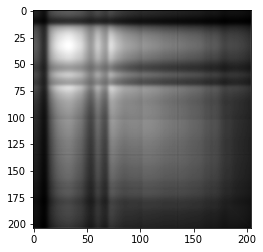

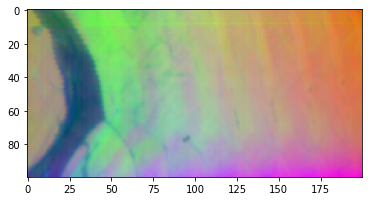

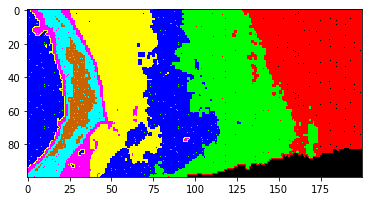

In [12]:
#principal components
pc = principal_components(data)
v = imshow(pc.cov)
pc_0999 = pc.reduce(fraction=0.999)
print(len(pc_0999.eigenvalues))
img_pc = pc_0999.transform(data)
v = imshow(img_pc[:,:,:3], stretch_all=True)

# now we can apply a classifier
classes = create_training_classes(img_pc, m)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(img_pc)
clmap_training = clmap * (m != 0)
v = imshow(classes=clmap_training)

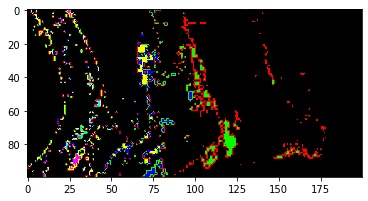

In [13]:
training_errors = clmap_training * (clmap_training != m)
v = imshow(classes=training_errors)
    

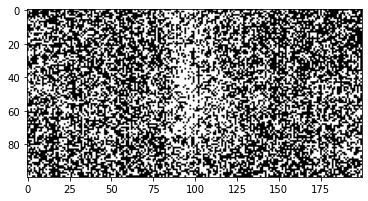

In [14]:
#Matched filter
mf = data[50,100]
mfscores = matched_filter(data, mf)
v = imshow(1 * (mfscores > 0.008))

Text(0.5, 1.0, 'sam')

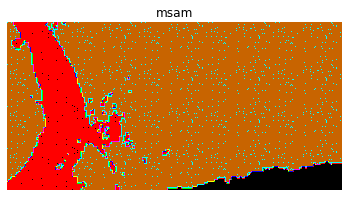

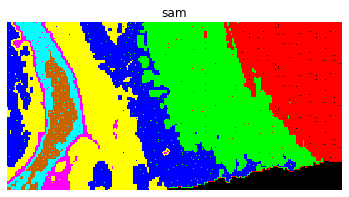

In [15]:
# Spectral Angle Mapper
classes = create_training_classes(data, m, True) # True parameter forces calculation of sttistics for each class
means = np.zeros((len(classes), data.shape[2]), float)
for (i, c) in enumerate(classes):
    means[i] = c.stats.mean
angles = msam(data, means)#spectral_angles(data, means)

angles1 = msam(data, means)
clmap1 = np.argmin(angles1, 2)
imshow(classes=((clmap1 + 1) * (m != 0)))
plt.axis('off')
plt.title('msam')

angles2 = spectral_angles(data, means)
clmap2 = np.argmin(angles2, 2)
imshow(classes=((clmap2 + 1) * (m != 0)))
plt.axis('off')
plt.title('sam')